<a href="https://www.nvidia.com/dli/"> <img src="https://developer.download.nvidia.com/training/images/DLI%20Header.png" alt="Header" style="width: 400px;"/> </a>

# Introduction
Text classification is a classic problem in Natural Language Processing.  Given multiple individual spans of texts (sentences, paragraphs, documents, etc.), the task is to assign each span one or multiple labels - or *classes* - out of $k$ possible ones.  Some possible applications of text classification are:

* Genre identification - Does this text contain news, sports, finance, etc?  
* Language detection - Is this text in English, German or any other language?
* Sentiment analysis - What type of sentiment (positive/negative/neutral) is present in this text?  Additionally, if multiple subjects or topics are discussed, what sentiment is associated with each such subject/topic? 

A particular type of text classification is the problem of *authorship attribution*.  In this task we are given some documents and a set of possible authors.  We then assign each document with a set of the authors who we believe wrote the document.  Presumably, we also have a large set of documents for which we know the authors already so we can extract features and characteristics to help us with the unknown ones.  

Authorship attribution is a well-studied problem which led to the field of [Stylometry](https://en.wikipedia.org/wiki/Stylometry).  As with many other NLP problems, it has benefited greatly from the increase in available computer power, data and advanced machine learning techniques.  All of these make authorship attribution a natural candidate for the use of deep learning (DL).  In particular, we can benefit from DL's ability to automatically extract the relevant features for a specific problem.

In this lab we will focus on the following:
1.  Building a *linguistic style model* to extract author-specific features from a set of texts (known as a *corpus*)
2.  Using these features for building a classification model for authorship attribution
3.  Applying the model for identifying the author of a set of unknown documents

# The Federalist Papers

The [Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)[1] are a set of essays written between 1787 and 1788 by [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton), [James Madison](https://en.wikipedia.org/wiki/James_Madison) and [John Jay](https://en.wikipedia.org/wiki/John_Jay).  Initially published under the pseudonym 'Publius', their intent was to encourage the ratification of the then-new Constitution of the United States of America.  In later years, a list emerged where the author of each one of the 85 papers was identified.  Nevertheless, for a subset of these papers the author is still in question.  The problem of the Federalist Papers authorship attribution has been a subject of much research in statistical NLP in the past (see the above Wikipedia article for details).   We will try to use Deep Learning to re-create this research.

In concrete terms, the problem is identifying - for each one of the disputed papers - whether Alexander Hamilton (AH) or James Madison (JM) are the authors.  We will assume that each paper has a single author (i.e., that no collaboration took place) and that each author has a well-defined writing style that is displayed across all the papers. 

## Approach
We will take the following approach with this problem:
* Use the non-disputed documents as labeled data for an end-to-end model.  The model is composed of two distinct parts (see Figure 1 below):

    1.  A linguistic  style feature extractor
    2.  A classifier
    

* Use the model to determine the author for each disputed paper

<img src="images/model.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 1**: Author Attribution Model </center></caption>

Let us now examine each model component in turn.

### Style Extraction

Given a sequence of tokens (subsets of the input text), we would like the extractor to return a representation of this sequence such that sequences with similar stylistic qualities have similar representations.  In other words, we would like to find a mapping from the sequence to a vector space that uses style properties as its basis.  Some possible properties that the extractor may learn include (but are not limited to):
* Where, when and how often punctuation is used
* Distribution of sentence length
* The use of specific vocabulary and syntactic constructions 

The above features are well-known in stylometry.  We would like, however, for the model to learn both these and other features that may be applicable.

In order to use sequences we will need models that can deal with time-varying inputs (i.e., multiple timesteps with different inputs at each timestep).  In our case, we will have one token every timestep and a fixed sequence length.  These will be our *hyperparameters* - a set of parameters that we determine empirically and that do not change during the training.  The model itself will be a Recurrent Neural Net (RNN) and specifically, a variant named [Long Short Term Memory (LSTM)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) that is ideally suited for NLP problems (see Figure 2).

<img src="images/lstm.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 2**: LSTM Cell </center></caption>

Ideally, our feature extractor will be a type of language model.  That is, given a set of tokens the model can predict the next token with high accuracy.  Let's look at an example:

> (1)   The cat sat on the X 

Looking at (1), we can make some assumptions about the token X:
* It is likely a noun (or more precisely, a [Noun Phrase](https://en.wikipedia.org/wiki/Noun_phrase)).  Otherwise, (1) may not be a grammatically-correct sentence.
* It is likely some piece of furniture.  Otherwise, there would not be agreement with the semantics of the verb *sat*. 

If we have such a model available - namely, one that predicts sequences that appear in our training data with high probability - the natural conclusion is that is has learned how our authors tend to write and we can then attempt to use that knowledge.  Here we encounter our primary issue:  training language models on words requires potentially millions of examples.  We have a relatively small corpus, so a word language model may severely overfit (in other words, this model may pick up specific patterns that just happen to appear in our corpus).  This is a tough issue - fortunately, in this case it is easy to overcome.  Since our corpus is composed of proper English text (i.e., no foreign characters or emojis) we can simply use *characters* as the tokens and not words.  For example, given the phrase "to the people of New York", we will have the sequence:
['t', 'o', ' ', 't', 'h', 'e', ' ', 'p',...] 
Note that whitespace and punctuation are also characters and will be part of the sequences.  This will hopefully assist us in learning the features mentioned above.  

Another trick we can use is to use character *embeddings* as opposed to just the characters themselves (for instance, in a 1-hot encoded representation). Recall that embeddings are dense representations of data that can learn the semantics of the domain.  Here the terminology may be a bit confusing, but the final result is that the embedding of a single character can represent features about the *context* of the character: which characters tend to appear before and/or after this one.  This is precisely what we need.

So the structure of our style feature encoder is as follows:

* A sequence of characters (length of sequence is a hyperparameter)
* An embedding layer for characters (dimensionality of the embedding is a hyperparameter)
* LSTM layer for learning a sequence representation (dimensionality of LSTM output is a hyperparameter).  We will use the output of the LSTM at the end of the sequence as our output.  This is known as a *context vector* (or *state vector*) - it encodes details about a particular sequence of characters that can be used by the classifier.

### Classifier

As noted above, the output of the style feature extractor (or *feature encoder*) is a fixed-size vector.  We use this vector as the input to a simple multi-layer feed-forward network.  Each layer in the network can then extract features that help it determine whether the character sequence (that is, the fixed-size *representation*) was written by AH or JM.  The final layer is composed of a single neuron with a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation, so that the entire model's output $y$ is constrained to be $0 \leq y \leq 1$.  Hence, the output can be interpreted as the probability that $y = 1$ or equivalently - given that we arbitrarily assigned the value 1 to JM and 0 to AH - that the sequence was written by JM.  This is easily extendable to multiple ($k \gt 2$) authors by using $k$ neurons in the final layer with a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation.

A very useful property of the entire model (both the feature encoder and the classifier) is that it can be trained end-to-end - there is no need for specifically building either the feature encoder or classifier.  Furthermore, it also means that we can use this model to easily infer the author of each of the disputed papers.  For each such document, we perform the following procedure:

1.  Break the entire document to sequences of the same length, as determined by the hyperparameter
2.  Retrieve an author prediction for each one of these sequences
3.  Determine which author has received more 'votes'.  We will then use this author as our prediction for the entire document.  (Note:  in order to have a clear majority, we need to ensure that the number of sequences is odd).



## Building the Model

We begin by setting up the data pre-processing pipeline.  For each one of the authors, we aggregate all the known papers into a single long text.  Recall that we assume that style does not change across the various papers, hence a single text is equivalent to multiple small ones yet it is much easier to deal with programmatically.

For each paper of each author we perform the following steps:
* Convert all text into lower-case (ignoring the fact that capitalization may be a stylistic property)
* Converting all newlines and multiple whitespaces into single whitespaces
* Remove any mention of the authors' names, otherwise we risk [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) 

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Constants for Hamilton/Madison
AH = 0
JM = 1
UNKNOWN = -1


def preprocess_text(file_path):
    """ Read and preprocess the text from a specific file.
        Preprocessing includes:
        * Replace newlines by spaces
        * Replace double spaces by single spaces
        * Lower-cases the text
        * Removes the names of the authors
        
    # Arguments
        file_path: the path to read the file from
        
    # Returns
        The preprocessed file
    
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
        text = ' '.join(lines[1:]).replace("\n", ' ').replace('  ',' ').lower().replace('hamilton','').replace('madison', '')
        text = ' '.join(text.split())
        return text


# Concatenate all the papers known to be written by Hamilton/Madisson into a single long text
all_hamilton, all_madison = '',''
for x in os.listdir('./federalist_papers/AH/'):
    all_hamilton += preprocess_text('./federalist_papers/AH/' + x)

for x in os.listdir('./federalist_papers/JM/'):
    all_madison += preprocess_text('./federalist_papers/JM/' + x)
    
# Print lengths of the large texts
print("Hamilton text length: {}".format(len(all_hamilton)))
print("Madison text length: {}".format(len(all_madison)))

Hamilton text length: 672168
Madison text length: 271345


Note that there is much more text available for AH than JM.  We will need to address this issue in order to not bias the model towards AH.

The next step is to break the long text for each author into many small sequences.  As described above, we empirically choose a length for the sequence and use it throughout the model's lifecycle.  We get our full dataset by labeling each sequence with its author.

To break the long texts into smaller sequences we use the *Tokenizer* class from the Keras framework.  In particular, note that we set it up to tokenize according to *characters* and not words.

In [2]:
from keras.preprocessing.text import Tokenizer


# Hyperparameter - sequence length to use for the model
SEQ_LEN = 30


def make_subsequences(long_sequence, label, sequence_length=SEQ_LEN):
    """ Breaks a large sequence into multiple smaller sequences of specified length
    
    # Arguments
        long_sequence: the long sequence to break into smaller sequences
        label: the label to assign to each subsequence
        sequence_length: the length of each subsequence
        
    # Returns
        X: matrix of size [len_sequences - sequence_length, sequence_length] with subsequence data
        y: matrix of size [len_sequences - sequence_length, 1] with label data
    
    """
    len_sequences = len(long_sequence)
    X = np.zeros(((len_sequences - sequence_length)+1, sequence_length))
    y = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
        X[i] = long_sequence[i:i+sequence_length]
        y[i] = label
    return X,y
        
# We use the Tokenizer class from Keras to convert the long texts into a sequence of characters (not words)

tokenizer = Tokenizer(char_level=True)

# Make sure to fit all characters in texts from both authors
tokenizer.fit_on_texts(all_hamilton + all_madison)

madison_long_sequence = tokenizer.texts_to_sequences([all_madison])[0]
hamilton_long_sequence = tokenizer.texts_to_sequences([all_hamilton])[0]

# Convert the long sequences into sequence and label pairs
X_madison, y_madison = make_subsequences(madison_long_sequence, JM)
X_hamilton, y_hamilton = make_subsequences(hamilton_long_sequence, AH)

# Print sizes of available data
print("Number of characters: {}".format(len(tokenizer.word_index)))
print('Madison sequences: {}'.format(X_madison.shape))
print('Hamilton sequences: {}'.format(X_hamilton.shape))

Using TensorFlow backend.


Number of characters: 53
Madison sequences: (271316, 30)
Hamilton sequences: (672139, 30)


In [7]:
print(len(madison_long_sequence))

271345


Compare the number of raw characters to the number of labeled sequences for each author.  Deep Learning requires many examples of each input.  The following code calculates the number of total and unique words in the texts.

In [8]:
# Calculate the number of unique words in the text

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts([all_madison, all_hamilton])

print("Total word count: ", len((all_madison + ' ' + all_hamilton).split(' ')))
print("Total number of unique words: ", len(word_tokenizer.word_index))

Total word count:  158673
Total number of unique words:  8250


**Exercise**:  Do you think a word or a character embedding model is appropriate here?  Write down your reasoning in the following cell.

We now proceed to create our train, validation and test sets.  

We begin by addressing the discrepancy  in the amounts of data available for AH vs. JM.  We choose a simple solution here by choosing the same number of sequences for AH as are available for JM and discarding the rest.  Depending on the performance of the model, this may or may not be a good idea in general.

We then create the various datasets:
* The *training* set is used by the model to learn the weights in the neural network.  The model will iterate over this data many times, until performance is deemed to be acceptable.  A single pass through all the data is known as an *epoch*.  Each training loop works on a subset of the data known as a *mini-batch*.  The number of instances in this mini-batch is known as the *batch size*.
* The *validation* set is used at the end of each epoch to assess performance of the model.  We present the model with data it *has not* seen before in order to evaluate its ability to *generalize*.  Had we used the training set instead, the model would have no 'motivation' to learn the internal structure of the data - it would just try to 'memorize' the original data.  We stop the training when the validation set performance begins to drop, as this means that the model now specializes (i.e, overfits) on the training set and is losing its ability to deal with unseen data.
* The *test* set is the final measure of performance that we report for the model.  Once again, we feed the model with data that it has not seen before in order to see how well it can generalize.  We do not use the validation set as we have already used it to determine when to stop training, so effectively our model is biased towards good validation performance.  The test set is a brand new set of data that should only be used at the end of the model training procedure.

We take 80% of the original data for the training set, and use the remaining 20% for test.  We then split the resulting training set again, and use 90% for actual training and the other 10% for validation.

**Exercise**:  Make sure that the data is in the proper shape for use in an RNN.  See [here](#hint1 "X_train = X_train.reshape(-1,SEQ_LEN,1)
X_test = X_test.reshape(-1,SEQ_LEN,1)") for a hint.

In [10]:

# Take equal amounts of sequences from both authors
X = np.vstack((X_madison, X_hamilton[:X_madison.shape[0]]))
y = np.vstack((y_madison, y_hamilton[:y_madison.shape[0]]))

# Break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

# Data is to be fed into RNN - ensure that the actual data is of size [batch size, sequence length, 1]
X_train = X_train.reshape(-1,SEQ_LEN,1)
X_test =  X_test.reshape(-1,SEQ_LEN,1)

# Break train set into train and validation
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.9)

# Print the shapes of the train, validation and test sets
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_validate shape: {}".format(X_validate.shape))
print("y_validate shape: {}".format(y_validate.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (390694, 30, 1)
y_train shape: (390694, 1)
X_validate shape: (43411, 30, 1)
y_validate shape: (43411, 1)
X_test shape: (108527, 30, 1)
y_test shape: (108527, 1)


Finally, we construct the model graph and perform the training procedure.  Notice how each part of the model we describe above is implemented in Tensorflow code.

A single training epoch takes around 8.5 minutes on a K80 GPU.  We have therefore provided pretrained weights for the model at 1, 10 and 20 epochs.  Simply run the code with no changes to use the pretrained weights.  If you'd like to perform the training yourself, change the value of the RUN_TRAINING variable in the second cell below to True.  You can also control the number of training epochs using the NUM_EPOCHS variable.

**Exercise**:  Complete the code for the tensorflow layers below.

See [hint](#hint2 "result = tf.nn.embedding_lookup(embeddings, sequences)") for the embedding layer

See [hint](#hint3 "lstm = tf.contrib.rnn.LSTMCell(lstm_size)") for the LSTM layer

In [11]:
import tensorflow as tf


def build_model(sequences, embedding_size=100, lstm_size=256):
    """ Build the Tensorflow graph that implements the neural author attribution model
    
    # Arguments
        sequences: character sequence data of size (batch size, sequence lengths, 1)
        embedding_size: size of embedding vector to be generated for each character
        lstm_size: size of vector that will be output by the LSTM style model
        
    # Returns
        result: output of the entire model, a value between 0 and 1
        lstm_output: the last output of the LSTM for each input sequence
    
    """
    
    # Sequences need to be of type integer
    sequences = tf.cast(sequences, tf.int32)
    
    # Placeholder for determining train or test mode
    with tf.variable_scope("Options"):
        mode = tf.placeholder(tf.string, (), "mode")
        is_training = tf.equal("train", mode)
    
    # Layer for selecting character embeddings 
    with tf.variable_scope("Embeddings"):
        embeddings = tf.get_variable("embeddings", (len(tokenizer.word_index)+1, embedding_size,),
                                    initializer=tf.initializers.random_uniform(-0.5,0.5))
        result = tf.nn.embedding_lookup(embeddings,sequences)
                                 
    # Style model implemented using LSTM
    with tf.variable_scope("StyleModel"):
        
        # We use an LSTM in lieu of a generic RNN 
        lstm = tf.contrib.rnn.LSTMCell(lstm_size)
        
        result = tf.reshape(result, (-1, SEQ_LEN, embedding_size))
        result = tf.unstack(result, SEQ_LEN, 1)   # TF-specific way of feeding data to RNN cell
        result, _ = tf.contrib.rnn.static_rnn(lstm, result, dtype=tf.float32)
        lstm_value = result[-1]                   # Only take the last result from the LSTM

    # Fully-connected classification model on top of the LSTM output
                                 
    with tf.variable_scope("Hidden1"):
        w1 = tf.get_variable("w1", (lstm_size, 128), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b1 = tf.get_variable("b1", 128)
        result = tf.nn.relu(tf.matmul(lstm_value, w1) + b1)
        
        # Dropout should only be applied during training
        result = tf.layers.dropout(result, rate=0.4, training=is_training) 
                                 
    with tf.variable_scope("Hidden2"):
        w2 = tf.get_variable("w2", (128, 64), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b2 = tf.get_variable("b2", 64)
        result = tf.nn.relu(tf.matmul(result, w2) + b2)
        
        # Dropout should only be applied during training
        result = tf.layers.dropout(result, rate=0.3, training=is_training)   
                                 
    with tf.variable_scope("Output"):
        w3 = tf.get_variable("w3", (64, 1), initializer=tf.initializers.random_uniform(-0.07, 0.07))
        b3 = tf.get_variable("b3", 1)
        result = tf.nn.sigmoid(tf.matmul(result, w3) + b3)
        
    return result, lstm_value
 
   
    
       
def build_loss(logits, labels):
    """ Build the graph operations for calculating loss
    
    # Arguments
        logits: output value of the model, as a logit
        labels: real labels of the data
        
    # Returns
        loss: the loss value
        num_correct: number of instances that were correctly classified
    """
    loss = tf.losses.log_loss(labels, logits)
    
    preds = tf.round(logits)
    equality = tf.equal(tf.cast(labels, tf.float32), preds)
    num_correct = tf.reduce_sum(tf.cast(equality, tf.float32))
    
    return loss, num_correct
                                 

def build_training(loss, learning_rate=0.001):
    """ Build the graph operations for performing training
    
    # Arguments
        loss: loss value for the model
        learning_rate: the learning rate to use for the training procedure
    """
    return tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.95).minimize(loss)


The following cell contains the code to perform the training loop on our data.  Note the use of Tensorflow iterators for importing different datasets without changes to the code.

In [12]:
import time

### Hyperparameters
BATCH_SIZE = 4096  
NUM_EPOCHS = 20     # Change this to shorten training time at the expense of model performance



def make_dataset(X,y):
    """ Creates a dataset composed of (data, label) instances, to be used for feeding to training
    
    # Arguments
        X: the data to be used for training
        y: the labels to be used for training
        
    # Returns
        ds: a Dataset object to be used for creating iterators
    """
    ds = tf.data.Dataset.zip( 
                        (tf.data.Dataset.from_tensor_slices(X), tf.data.Dataset.from_tensor_slices(y))
                       ).shuffle(len(X), reshuffle_each_iteration=True).batch(BATCH_SIZE)
    return ds


def evaluate(dataset):
    """ Perform evaluation of the model given a specific dataset
    
    # Arguments
        dataset: the dataset to be used for the evaluation
        
    # Returns
        mean of the loss value over all batches in this dataset
        accuracy score for the dataset
    
    """
    
    # Initialize an iterator from the input dataset
    sess.run(data_iterator.make_initializer(dataset)) 
    
    
    total_inputs = 0;
    total_correct = 0;
    losses = []
    try:
        
        # Iterate over all batches in the iterator - an exception will be thrown to signal that no more 
        # data is available.
        while True:        
            logits_value, loss_value, value_correct  = sess.run([logits, loss, num_correct], 
                                    feed_dict={"Options/mode:0":"test"}) # Set dropout to test mode
            
            total_inputs += logits_value.shape[0]
            total_correct += value_correct
            losses.append(loss_value)
    except tf.errors.OutOfRangeError:
        # This exception is expected.  Simply continue.
        pass
    
    return np.mean(losses), total_correct / total_inputs 

def train():
    """ Perform a single training epoch of a model
        
    # Returns
        mean of the training loss value over all batches in this dataset
        accuracy score for the dataset
        duration: time elapsed for performing a single epoch 
    
    """
        
    # Initialize an iterator from the training dataset
    sess.run(data_iterator.make_initializer(train_ds))

        
    losses = []
    duration = 0
            
    accuracy = 0
    start = time.time()
    try:
        
        # Iterate over all batches in the iterator - an exception will be thrown to signal that no more 
        # data is available.
        while True:
            loss_value, _ = sess.run([loss, training_step], feed_dict={"Options/mode:0":"train"})
            losses.append(loss_value)
    except tf.errors.OutOfRangeError:
        # This exception is expected.  Simply continue.
        duration = time.time() - start

    return np.mean(losses), duration


def validate():
    """ Evaluate a validation set on a model
    
    # Returns
        Results of evaluating a validation set on a model
    """
    return evaluate(validate_ds)

def test():
    """ Evaluate a test set on a model
    
    # Returns
        Results of evaluating a test set on a model
    """
    return evaluate(test_ds)






tf.reset_default_graph()
g = tf.Graph()  
with g.as_default():
    with tf.name_scope("input"):

            # Build training, validation and test datasets of (data, label) instances
            train_ds = make_dataset(X_train, y_train)
            validate_ds = make_dataset(X_validate, y_validate)
            test_ds = make_dataset(X_test, y_test)

            # Build iterator of a specific shape (to be used for multiple datasets)
            data_iterator = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)

            # A single iterator will return batches of data and labels
            next_sequence, next_label = data_iterator.get_next()


    # Build a model along with its loss and training operators   
    logits, lstm_output = build_model(next_sequence)
    loss, num_correct = build_loss(logits, next_label)
    training_step = build_training(loss)


    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    saver = tf.train.Saver(max_to_keep=NUM_EPOCHS)

    sess = tf.Session(graph=g)
    
    
    ############# Flag for either training or restoring model from file #################
    RUN_TRAINING = False
    
    
    if not RUN_TRAINING:
        saver.restore(sess, "/dli/data/checkpoints/model.ckpt-20"); # Available checkpoints for 1, 10 and 20 epochs
        print("Restored model from file!")
    
    else:
    
        sess.run(init_op)

        # Run training and validation epochs    
        for epoch in range(1, NUM_EPOCHS+1):
            mean_train_loss, duration = train()
            mean_val_loss, accuracy = validate()
            save_path = saver.save(sess, "/dli/data/checkpoints/model.ckpt", global_step=epoch)
            print("Epoch {0} ({1:.3f} seconds), training loss {2:.5f}, validation loss {3:.5f}, validation accuracy {4:.3f}"\
                  .format(epoch, duration, mean_train_loss, mean_val_loss, accuracy))


        mean_test_loss, accuracy = test()
        print("Test loss: {0:.5f}, test accuracy:  {1:.3f}".format(mean_test_loss, accuracy))

    

    
    


INFO:tensorflow:Restoring parameters from /dli/data/checkpoints/model.ckpt-20
Restored model from file!


Once the model has finished training, compare the validation and test losses to the training loss.  Notice that the test and validation loss values are similar, but not identical.  This indicates that the validation set is a good approximation for the performance of the test set and the model's ability to generalize to new, unseen data.
Notice also that the model's training loss is lower that both validation and test loss.  This may indicate that the model is beginning to overfit by modelling the 'noise' in the training data.  A good rule-of-thumb is to stop the training when the validation loss begins to rise while the training loss continues to drop.



## Evaluating the Model

Once we have a trained model, we can proceed to evaluate the model's performance.  We will perform this evaluation in two ways:
1.  Check the output of the style feature encoder - does it coincide with our intuition of what it should be doing?
2.  Compare the output of the classifier with the published research on the disputed papers - how accurate is our model?

### Observing the Style Features Encoder
As described above, the output of the feature encoder is a fixed-size vector.  The dimension of this vector is determined by the *lstm_size* parameter in the *build_model* function above.  It is interesting to see what insights we can get from looking at this vector and how it applies to the overall model's performance.  

In the next cell, we create a new dataset that uses the test set and shuffles it.  Recall that the test set contains data that has not been used during the model's training in any way.  We shuffle it to make sure that we get random instances and in particular, that we do not get sequences that follow each other in the actual text.  We then run a single batch of data through the trained model.  However, rather than look at the final output, we take the output from the LSTM layer (which itself follows a character embedding layer).  We also make sure to include the real labels from this data.  Run this cell multiple times to extract subsequent batches for viewing.

In [15]:
with g.as_default():
    embeddings_ds = test_ds.shuffle(len(X_test))
    sess.run(data_iterator.make_initializer(embeddings_ds))
    lstm_vectors, real_labels = sess.run([lstm_output, next_label])

We would now like to get a visual idea of the style features vector.  In order to do this, we need to apply a [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) technique to transform the high-dimensional vector into a 2 or 3-dimensional vector which we can then visualize.  We do this with a technique called [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) and then plot the result.

NameError: name 'ticker' is not defined

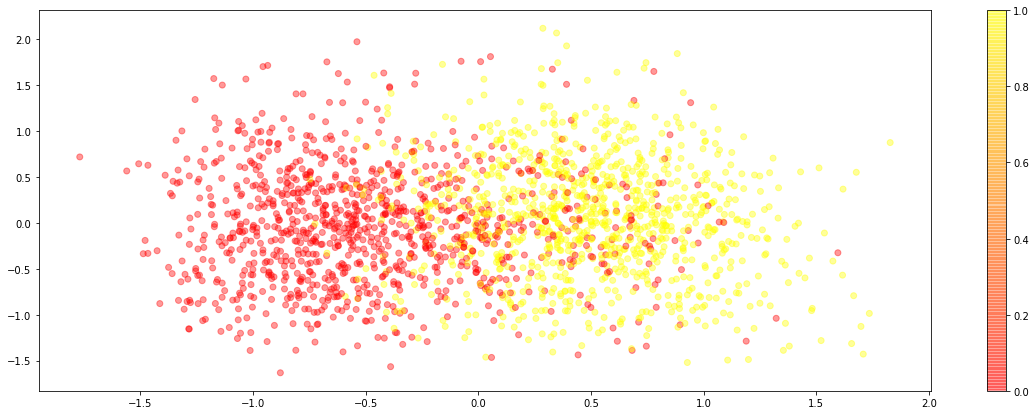

In [14]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

pca = PCA(n_components=2, random_state=12345)
transformed_values = pca.fit_transform(lstm_vectors)

plt.figure(figsize=(20,7))
plt.scatter(transformed_values[:,0], transformed_values[:,1], c=real_labels.ravel(), cmap='autumn', alpha=0.4)
colorbar = plt.colorbar();

def colorbar_labeler(value, _):
    if value == float(AH):
        return "AH"
    elif value == float(JM):
        return "JM"
    return ""

colorbar.formatter = ticker.FuncFormatter(colorbar_labeler)
colorbar.update_ticks()




There are two interesting observations we can make from this plot:
1.  The sequences in the test set seem to cluster together for each author, i.e. they are not randomly placed in the figure.  (If you have time, try reloading the model weights after a single epoch and then re-running the plot.)  This coincides with our hypothesis that each author has a specific style and that the model can learn to identify it.  
2.  The two clusters have a certain amount of overlap.  This is not surprising, as the authors use many similar words and phrases.  

Note, however, that the red cluster (AH) has a number of points (i.e., sequences) that seem to lie deep in the yellow cluster (JM).  Two possible interpretations for this phenomenon are as follows:
1.  Either AH occasionally uses vocabulary and style that closely resembles that of JM, or
2.  The labels are not correct.  Keep in mind that the data are just sequences from the text and *not* the entire text itself, so labels refer to whether AH or JM wrote a particular *sequence*.  Hence, this may point to the fact that some papers are actually *collaborations* between AH and JM.  What do you think?

Try running this extraction and visualization code multiple times.

__Optional: Using TSNE for Visualization__

When applying PCA, we chose to use only the 2 most significant principal components which only account for a small amount of variance in the data.  Since we cannot plot more than 3 components, we need to use a different method if we'd like a more detailed look.  Here we apply a method called [T-distributed Stochastic Neighbor Embedding (T-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

Because T-SNE is very computationally intensive (and unfortunately, we do not have a GPU implementation) we take a different approach:  we apply PCA to reduce dimensionality of the original vector, and apply T-SNE on the result.

In the following cell, change the NUM_DIMENSIONS parameter to control the amount of variance plotted, and the NUM_ITERATIONS parameter to change the computation time of the algorithm.  Note that this may take several minutes to run.

Explained variance: 38.89462959766388%


NameError: name 'ticker' is not defined

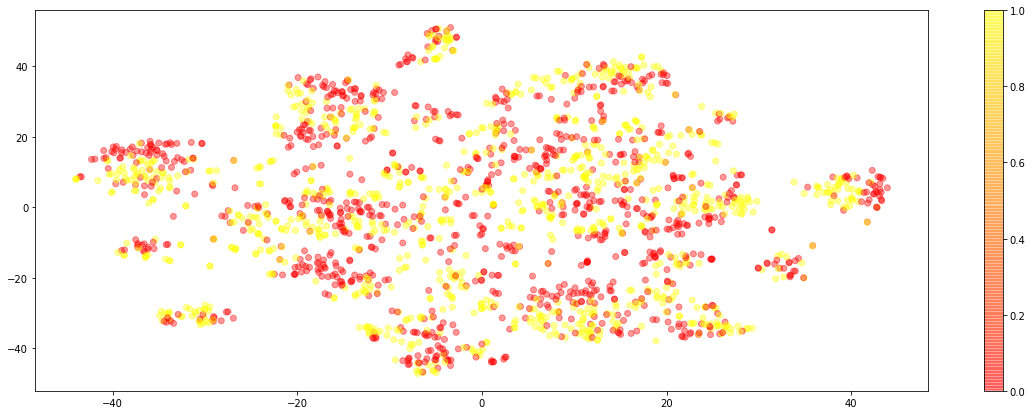

In [16]:
from sklearn.manifold import TSNE

NUM_DIMENSIONS = 30   
NUM_ITERATIONS = 500   # No less than 250

pca = PCA(n_components=NUM_DIMENSIONS, random_state=12345)
pca_values = pca.fit_transform(lstm_vectors)
print("Explained variance: {}%".format(sum(pca.explained_variance_ratio_ * 100)))

tsne = TSNE(n_iter=NUM_ITERATIONS)
transformed_values = tsne.fit_transform(pca_values)

plt.figure(figsize=(20,7))
plt.scatter(transformed_values[:,0], transformed_values[:,1], c=real_labels.ravel(), cmap='autumn', alpha=0.4)
colorbar = plt.colorbar();

colorbar.formatter = ticker.FuncFormatter(colorbar_labeler)
colorbar.update_ticks()

### Applying the Model to the Disputed Papers

We will now proceed to our original goal:  run the model on the disputed papers and observe the results.  To do that, we simply repeat the procedure we performed for the training data:  we read the original text, preprocess it to remove capitalization and standardize whitespace and convert to sequences.  We then run all sequences through the model and tally the results - the author with more votes is the 'winner'.

In [17]:
for x in sorted(os.listdir('./federalist_papers/unknown/')):

    disputed_text = preprocess_text('./federalist_papers/unknown/' + x)
    disputed_long_sequence = tokenizer.texts_to_sequences([disputed_text])[0]
    X_sequences, _ = make_subsequences(disputed_long_sequence, UNKNOWN)
    X_sequences = X_sequences.reshape((-1,SEQ_LEN,1))
    
    with g.as_default():
        
        votes_for_madison = 0
        votes_for_hamilton = 0
        
        dataset = make_dataset(X_sequences, np.zeros((X_sequences.shape[0], 1)))
        sess.run(data_iterator.make_initializer(dataset))
        
        try:
            while True:        
                predictions  = sess.run(tf.round(logits), feed_dict={"Options/mode:0":"test"})
                counts = np.unique(predictions, return_counts=True)[1]
                votes_for_hamilton += counts[AH]
                votes_for_madison += counts[JM]
            
        except tf.errors.OutOfRangeError:
            pass

        
        print("Paper {} is predicted to have been written by {}, {} to {}".format(
                x.replace('paper_','').replace('.txt',''), 
                ("Alexander Hamilton" if votes_for_hamilton > votes_for_madison else "James Madison"),
                max(votes_for_hamilton, votes_for_madison), min(votes_for_hamilton, votes_for_madison)))
        
        


Paper 49 is predicted to have been written by James Madison, 5506 to 4573
Paper 50 is predicted to have been written by James Madison, 3923 to 2982
Paper 51 is predicted to have been written by James Madison, 6640 to 5088
Paper 52 is predicted to have been written by James Madison, 5834 to 5268
Paper 53 is predicted to have been written by James Madison, 6675 to 6437
Paper 54 is predicted to have been written by James Madison, 6509 to 5373
Paper 55 is predicted to have been written by James Madison, 6840 to 5286
Paper 56 is predicted to have been written by James Madison, 4942 to 4675
Paper 57 is predicted to have been written by James Madison, 6662 to 6489
Paper 58 is predicted to have been written by James Madison, 6655 to 6070
Paper 62 is predicted to have been written by James Madison, 7885 to 6300
Paper 63 is predicted to have been written by James Madison, 10149 to 8154


Compare the results from our model to those listed [here](https://en.wikipedia.org/wiki/The_Federalist_Papers#Complete_list).  How did we do?

In [ ]:
# Close Tensorflow session and free GPU resources
sess.close()

# Summary

In this lab, we discussed the problem of authorship attribution.  We presented the Federalist Papers debate, and built a Deep Learning model to address it.  Finally, we looked at the model internals to get an intuition for how the it encodes stylometric properties.

For the Federalist Papers, we know for a fact that each debated paper was written by either Alexander Hamilton or James Madison.  Therefore we used a model that will output one or the other.  More generally, we could have used a model that returns *confidence levels* for each author - we would then have multiple sigmoid outputs, each giving us the probability of the input text having been written by an author.  If no sigmoid exceeds a certain threshold (for example, 0.5), we can declare that text's author as unknown.

Authorship attribution is a type of a *text classification* problem, which are very pervasive.  The models and approach you saw here are very relevant to many types of text classification.

# Assessment: Categorize words


Modify [Sense2Vec.py](../../../../edit/tasks/task2/task/Sense2Vec.py) by filling in all the **##TODO##** in the file to categorize all the words into verbs and nouns.

Test your solution with the following command:

In [21]:
!python3 Sense2Vec.py

Using TensorFlow backend.
VERB
NOUN
NOUN
NOUN
VERB
NOUN
NOUN
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
VERB
NOUN
Train on 144 samples, validate on 16 samples
Epoch 1/170
2018-10-22 18:53:26.738769: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-10-22 18:53:26.803693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-10-22 18:53:26.803973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1405] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 483.19MiB
2018-10-22 18:53:26.804004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1484] Adding visible gpu devices: 0


 - 0s - loss: 0.6083 - acc: 0.7986 - val_loss: 1.7856 - val_acc: 0.8125
Epoch 80/170
 - 0s - loss: 0.6060 - acc: 0.7986 - val_loss: 2.1121 - val_acc: 0.8125
Epoch 81/170
 - 0s - loss: 0.5884 - acc: 0.8056 - val_loss: 1.8249 - val_acc: 0.8125
Epoch 82/170
 - 0s - loss: 0.5971 - acc: 0.8056 - val_loss: 2.1761 - val_acc: 0.8125
Epoch 83/170
 - 0s - loss: 0.5978 - acc: 0.7986 - val_loss: 1.8827 - val_acc: 0.8125
Epoch 84/170
 - 0s - loss: 0.6092 - acc: 0.7986 - val_loss: 1.6982 - val_acc: 0.8125
Epoch 85/170
 - 0s - loss: 0.6014 - acc: 0.7986 - val_loss: 2.3424 - val_acc: 0.8125
Epoch 86/170
 - 0s - loss: 0.6159 - acc: 0.7986 - val_loss: 2.0656 - val_acc: 0.8125
Epoch 87/170
 - 0s - loss: 0.6018 - acc: 0.7986 - val_loss: 2.3667 - val_acc: 0.8125
Epoch 88/170
 - 0s - loss: 0.6051 - acc: 0.7986 - val_loss: 1.9456 - val_acc: 0.8125
Epoch 89/170
 - 0s - loss: 0.6005 - acc: 0.7986 - val_loss: 2.2704 - val_acc: 0.8125
Epoch 90/170
 - 0s - loss: 0.6080 - acc: 0.8056 - val_loss: 2.1716 - val_acc: 

**After completing this, go back in the browser page you used to open this notebook and click the ASSESS TASK button. If you have categorized your words correctly then you will pass this assessment.**

### References
[1] The complete text of the Federalist Papers are available from Project Gutenberg [here](http://www.gutenberg.org/ebooks/18).  The data has been split into multiple files for your convenience, and those by John Jay have been removed.